# 18 - Exploration of Historical NBA Players (Part VIII, WS & VORP)
Let's get right into it. Last post, I looked at, well, really I _**learned**_ what PER, BPM, VORP, and WS were. Basketball-referece's blurbs now make _**some**_ sense to me haha:
- _**PER**_ - Sum up all a player's positive accomplishments, subtract the negative accomplishments, and return a per-minute rating of a player's performance
- _**BPM**_ - Box score estimate of the points per 100 possessions that a player contributed above a league-average player, translated to an average team
- _**VORP**_ - Convert the BPM rate into an estimate of each player's overall contribution to the team, measured vs. what a theoretical "replacement player" would provide, where the "replacement player" is defined as a player on minimum salary or not a normal member of a team's rotation, accounting for amount of playing time
- _**WS**_ - A player statistic which attempts to divvy up credit for team success to the individuals on the team. Important things to note are that it is calculated using player, team and league-wide statistics and the sum of player win shares on a given team will be roughly equal to that team’s win total for the season

I took a look at how these stats are distributed throughout seasons in the past, and I left off wondering what the difference between VORP and WS was. I made the possibly unethical decision to skip over the math itself and just look at correlations with players to see if I could spot the differences by correlating it with the opinions of media voting. For this, I'll be looking at the all-NBA and all-star teams.

## All-NBA & All-Star Team Correlation to VORP & WS
To me, the all-NBA team is probably the best measure of subjective success. First runner up to that is all-star selections, which is definitely not as concrete because voting starts within the first half of the season (the season has barely began in the grand scheme of things) and the starters are voted in by the fans (which changed this year to 50% media voting because the fans are horrible, horrible people, including myself). Both are interesting in their own right, and at the end of the day, usually bubble up the best players in the league (whether individual or team)

The all-NBA teams are constructed of _**three teams**_, each with _**five players**_. These guys are voted in by media and broadcasting people, so, while they aren't the players or coaches themselves, they're at least more knowledgable people about the game than the lowly fans (see the 2017 Zaza Pachulia almost mishap). Generally, there is a G / G / F / F / C lineup. I guess it tries to balance all the positions, which may be a pro or con depending on how you look at things. This can be correct or incorrect depending on the year. If all the centers are garbage that year, a center still has to be chosen and may get the spot over a more deserving forward... etc. The all-star rules have relaxed on the F / C distinction, and perhaps could hedge this a ltitle bit so I'll somewhat reluctantly add in all-stars as well.

Let's scrape bball-ref for all-nba and all-star information.

In [2]:
# Load libraries & initial config
%load_ext rpy2.ipython

%R library(ggplot2)
%R library(gridExtra)
%R library(scales)
%R library(ggbiplot)

%matplotlib nbagg
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import boto3
from StringIO import StringIO
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Retrieve team stats from S3
playerAggDfToAnalyze = pd.read_csv('https://s3.ca-central-1.amazonaws.com/2017edmfasatb/fas_boto/data/playerAggDfToAnalyze.csv', index_col = 0)

pd.set_option('display.max_rows', len(playerAggDfToAnalyze.dtypes))
print playerAggDfToAnalyze.dtypes
pd.reset_option('display.max_rows')

# Filter to remove outliers, player must have played over 10 minutes and in over 20 games on the season
playerAggDfToAnalyzeMin10Min20Games = playerAggDfToAnalyze[(playerAggDfToAnalyze['perGameStats_MP'] > 10) & (playerAggDfToAnalyze['perGameStats_G'] > 20)]

season_start_year          int64
perGameStats_Player       object
perGameStats_Pos          object
perGameStats_Age           int64
perGameStats_Tm           object
perGameStats_G             int64
perGameStats_GS          float64
perGameStats_MP          float64
per100Stats_FG           float64
per100Stats_FGA          float64
per100Stats_FGPerc       float64
per100Stats_3P           float64
per100Stats_3PA          float64
per100Stats_3PPerc       float64
per100Stats_2P           float64
per100Stats_2PA          float64
per100Stats_2PPerc       float64
per100Stats_FT           float64
per100Stats_FTA          float64
per100Stats_FTPerc       float64
per100Stats_ORB          float64
per100Stats_DRB          float64
per100Stats_TRB          float64
per100Stats_AST          float64
per100Stats_STL          float64
per100Stats_BLK          float64
per100Stats_TOV          float64
per100Stats_PF           float64
per100Stats_PTS          float64
per100Stats_ORtg         float64
per100Stat

### Scrape All-NBA Team Information
All-NBA team information is cleanly laid out within basketball-reference [here](http://www.basketball-reference.com/awards/all_league.html).

It's all in one table, so that makes for easy scraping, but we see there are definitely some formatting considerations that we have to knock down before going any further after scraping:
- Season will have to be cleaned up to only show the starting year of the season (to match our dataframe of players)
- The player names have the position following it, I'll have to strip the positions out as I'm not so concerned about these right now
- The format of the table is not what I'd like as well if I'm to join and look these values back up into the main dataframe table, examples of the current format and my desired format are below

#### Current Data Format

In [4]:
pd.DataFrame(['2015-16', '1st', 'DeAndre Jordan C', 'Kawhi Leonard F', 'LeBron James F', 'Stephen Curry G', 'Russell Westbrook G']).transpose().rename(columns = {0: 'Season', 1: 'Tm', 2: '', 3: '', 4: '', 5: '', 6: ''})

,Season,Tm,,,,,
0,2015-16,1st,DeAndre Jordan C,Kawhi Leonard F,LeBron James F,Stephen Curry G,Russell Westbrook G


#### Desired Data Format

In [5]:
pd.DataFrame({
   'Season': [2015, 2015, 2015, 2015, 2015],
    'Tm': ['1st', '1st', '1st', '1st', '1st'],
    'Player': ['DeAndre Jordan', 'Kawhi Leonard', 'LeBron James', 'Stephen Curry', 'Russell Westbrook']
})[['Season', 'Tm', 'Player']]

,Season,Tm,Player
0,2015,1st,DeAndre Jordan
1,2015,1st,Kawhi Leonard
2,2015,1st,LeBron James
3,2015,1st,Stephen Curry
4,2015,1st,Russell Westbrook


Let's scrape!

In [6]:
# Format URL to scan
urlToScan = 'http://www.basketball-reference.com/awards/all_league.html'

# Pull data from HTML table
allNbaDf = pd.read_html(
    io = urlToScan,
    header = None,
    attrs = {'class': 'stats_table'}
)[0]

# Fix some formatting issues (extra header rows in the middle of table) from bball ref
allNbaDf = allNbaDf.dropna()
allNbaDf.columns = ['Season', 'Lg', 'Tm', 'C', 'F1', 'F2', 'G1', 'G2']

# Use pandas melt function to repivot to my desired format
allNbaDfFormatted = pd.melt(
    allNbaDf, 
    id_vars = ['Season', 'Lg', 'Tm'], 
    value_vars = ['C', 'F1', 'F2', 'G1', 'G2'],
    var_name = 'Position',
    value_name = 'Player'
)

# Fix remainder of formatting issues
#   Removing position from player name field (e.g. Lebron James F)
allNbaDfFormatted['Player'] = allNbaDfFormatted['Player'].replace(' [FCG]{1}$', '', regex = True)
allNbaDfFormatted['season_start_year'] = allNbaDfFormatted['Season'].apply(lambda x: x[:4])

allNbaDfFormatted = allNbaDfFormatted[[
    'season_start_year',
    'Tm',
    'Player'
]]

# Change season_start_year to int to match master dataframe
allNbaDfFormatted['season_start_year'] = allNbaDfFormatted['season_start_year'].astype(int)

print allNbaDfFormatted

     season_start_year   Tm                          Player
0                 2015  1st                  DeAndre Jordan
1                 2015  2nd                DeMarcus Cousins
2                 2015  3rd                  Andre Drummond
3                 2014  1st                      Marc Gasol
4                 2014  2nd                DeMarcus Cousins
5                 2014  3rd                  DeAndre Jordan
6                 2013  1st                     Joakim Noah
7                 2013  2nd                   Dwight Howard
8                 2013  3rd                    Al Jefferson
9                 2012  1st                      Tim Duncan
10                2012  2nd                      Marc Gasol
11                2012  3rd                   Dwight Howard
12                2011  1st                   Dwight Howard
13                2011  2nd                    Andrew Bynum
14                2011  3rd                  Tyson Chandler
15                2010  1st             

### Scrape All-Star Team Information

Unfortunately, the all-star team information isn't broken down as easily as the all-NBA information is on basketball-reference. In fact, I couldn't actually find the data in the same format. I think you'd have to go year by year through the different all-star pages to get the actual rosters.

Kind of a hack, but I found this [website](http://www.nba-allstar.com/allstargame/rosters.htm) that sums the rosters up pretty nicely on one page that's conducive to scraping. The formatting is a bit wonky, but it should be too hard to follow these steps:
1. Scrape and get all the tables into an array
2. Loop through array and, for each table (per season)
    3. Extract the season (the season here is the third column of the headers) and subtract one to get the start year of the season
    4. Extract the east and west players and append them to a master dataframe

Leggo.

In [7]:
# Format URL to scan
urlToScan = 'http://www.nba-allstar.com/allstargame/rosters.htm'

# Pull data from HTML table, every year's all-star roster table is in a dataframe within this list
allStarTableList = pd.read_html(
    io = urlToScan,
    header = None,
    attrs = {'class': 'stats'}
)

print 'There have been {} all star games'.format(len(allStarTableList))

There have been 66 all star games


In [8]:
# Loop through list of all star rosters and compile in a master dataframe
allStarDf = None

for table in allStarTableList:
    # Extract the year from the table, minus 1 to get season_start_year
    year = table[2][0] - 1

    # Extract the columns of names that are the east and west all stars
    eastAllStars = table[0][1:].dropna()
    westAllStars = table[3][1:].dropna()
    
    # Concatenate east and west all stars (currently stored as a pandas series) to pandas dataframe
    concatDf = pd.DataFrame({
        'Player': pd.concat([eastAllStars, westAllStars])
    })
    
    # Fill in year as an extra column on dataframe so we can use to join back to master dataframe later
    concatDf['season_start_year'] = year
    
    # Append this year's all stars to the aggregate all star dataframe
    if allStarDf is None:
        allStarDf = concatDf
    else:
        allStarDf = pd.concat([allStarDf, concatDf])

# Add a label to join back into the master dataframe later
allStarDf['all_star'] = 'All Star'

# Change season_start_year to int to match master dataframe
allStarDf['season_start_year'] = allStarDf['season_start_year'].astype(int)

print allStarDf

                   Player  season_start_year  all_star
1            Kyrie Irving               2016  All Star
2           DeMar DeRozan               2016  All Star
3            Lebron James               2016  All Star
4   Giannis Antetokounmpo               2016  All Star
5            Jimmy Butler               2016  All Star
6           Isaiah Thomas               2016  All Star
7              Kyle Lowry               2016  All Star
8            Kemba Walker               2016  All Star
9             Paul George               2016  All Star
10             Kevin Love               2016  All Star
11           Paul Millsap               2016  All Star
12              John Wall               2016  All Star
13        Carmelo Anthony               2016  All Star
1           Stephen Curry               2016  All Star
2            James Harden               2016  All Star
3            Kevin Durant               2016  All Star
4           Kawhi Leonard               2016  All Star
5         

### Joining Data Back to Master Dataframe
Okay, so I have the data now by player and year, and can probably join this back to the master dataframe. How do I join? Names is always an interesting field to join on because of its inconsistent nature.

Let's take the following names:
- Shaquille O'Neal
- Shaquille O Neal
- Shaq
- shaquille oneal

These are of course the same person, but neither me nor my computer are smart enough to perform this fuzzy matching at a large scale. Or rather, there's probably not the need to have to dive into that much detail when cleaning up the names are good enough for this specific use case.

If I make the assumption that these reference websites are using a players FULL NAMES
- Stephen Curry, not "Steph" Curry
- Carmelo Anthony, not "Melo"
- Shaquille O'Neal, not "Shaq O'Neal"

I think I'd basically just be able to change all characters to lower case and strip out anything not alphanumeric
- Stephen Curry becomes stephencurry
- Carmelo Anthony becomes carmeloanthony
- Shaquille O'Neal becomes shaquilleoneal

I don't believe I've ever seen two players with the exact same name in the all-star game, so there shouldn't be any duplicate joins... WELP, LET'S TRY THIS.

In [9]:
# Format player names in each dataframe to join
playerAggDfToAnalyzeMin10Min20Games['player_formatted'] = playerAggDfToAnalyzeMin10Min20Games['perGameStats_Player'].str.lower().replace('\W', '', regex = True)
allNbaDfFormatted['player_formatted'] = allNbaDfFormatted['Player'].str.lower().replace('\W', '', regex = True)
allStarDf['player_formatted'] = allStarDf['Player'].str.lower().replace('\W', '', regex = True)

# Join dataframes
playerAggDfAllNbaAllStar = playerAggDfToAnalyzeMin10Min20Games.merge(
    allNbaDfFormatted,
    how = 'left',
    on = ['player_formatted', 'season_start_year']
).merge(
    allStarDf,
    how = 'left',
    on = ['player_formatted', 'season_start_year']
)

print playerAggDfAllNbaAllStar[playerAggDfAllNbaAllStar['player_formatted'] == 'lebronjames'][[
    'perGameStats_Player',
    'player_formatted',
    'season_start_year',
    'Tm',
    'all_star'
]]

      perGameStats_Player player_formatted  season_start_year   Tm  all_star
7565         LeBron James      lebronjames               2003  NaN       NaN
7993         LeBron James      lebronjames               2004  2nd  All Star
8406         LeBron James      lebronjames               2005  1st  All Star
8798         LeBron James      lebronjames               2006  2nd  All Star
9189         LeBron James      lebronjames               2007  1st  All Star
9597         LeBron James      lebronjames               2008  1st  All Star
10014        LeBron James      lebronjames               2009  1st  All Star
10464        LeBron James      lebronjames               2010  1st  All Star
10866        LeBron James      lebronjames               2011  1st  All Star
11261        LeBron James      lebronjames               2012  1st  All Star
11688        LeBron James      lebronjames               2013  1st  All Star
12111        LeBron James      lebronjames               2014  1st  All Star

Noice! I got the all-NBA and all-star flags in my dataframe now. Seems to make sense. I guess Lebron didn't make any teams in his first season, and basically has just been owning the league since then. 2016 all-NBA is missing because it hasn't been announced yet, but otherwise evertying else looks right!

Let's just check shaq for quality control as well.

In [10]:
print playerAggDfAllNbaAllStar[playerAggDfAllNbaAllStar['player_formatted'] == 'shaquilleoneal'][[
    'perGameStats_Player',
    'player_formatted',
    'season_start_year',
    'Tm',
    'all_star'
]]

      perGameStats_Player player_formatted  season_start_year   Tm  all_star
4001    Shaquille O'Neal*   shaquilleoneal               1992  NaN  All Star
4329    Shaquille O'Neal*   shaquilleoneal               1993  3rd  All Star
4658    Shaquille O'Neal*   shaquilleoneal               1994  2nd  All Star
5011    Shaquille O'Neal*   shaquilleoneal               1995  3rd  All Star
5412    Shaquille O'Neal*   shaquilleoneal               1996  3rd  All Star
5779    Shaquille O'Neal*   shaquilleoneal               1997  1st  All Star
6164    Shaquille O'Neal*   shaquilleoneal               1999  1st  All Star
6525    Shaquille O'Neal*   shaquilleoneal               2000  1st  All Star
6903    Shaquille O'Neal*   shaquilleoneal               2001  1st  All Star
7255    Shaquille O'Neal*   shaquilleoneal               2002  1st  All Star
7664    Shaquille O'Neal*   shaquilleoneal               2003  1st  All Star
8082    Shaquille O'Neal*   shaquilleoneal               2004  1st  All Star

Okay, we see a few duplicates here actually, but this is when he was traded midseason from MIA to PHO, so no worries it's not a product of the join.

I'm just going to make a single column now with both accolades reflected in one column. I think the highest honour is to be named to the all-NBA teams, but if they didn't make an all-NBA teams and they made an all-star team, that's worth nothing as well. The final column will have these labels, with the following priority:
- All-NBA First Team
- All-NBA Second Team
- All-NBA Third Team
- All-Star Team

In [11]:
playerAggDfAllNbaAllStar['accolades'] = np.where(
    playerAggDfAllNbaAllStar['Tm'] == '1st',
    'All-NBA First Team',
    np.where(
        playerAggDfAllNbaAllStar['Tm'] == '2nd',
        'All-NBA Second Team',
        np.where(
            playerAggDfAllNbaAllStar['Tm'] == '3rd',
            'All-NBA Third Team',
            np.where(
                playerAggDfAllNbaAllStar['all_star'] == 'All Star',
                'All-Star Team',
                'No Team'
            )
        )
    )
)

In [12]:
print playerAggDfAllNbaAllStar[playerAggDfAllNbaAllStar['player_formatted'] == 'shaquilleoneal'][[
    'perGameStats_Player',
    'season_start_year',
    'accolades'
]]

      perGameStats_Player  season_start_year            accolades
4001    Shaquille O'Neal*               1992        All-Star Team
4329    Shaquille O'Neal*               1993   All-NBA Third Team
4658    Shaquille O'Neal*               1994  All-NBA Second Team
5011    Shaquille O'Neal*               1995   All-NBA Third Team
5412    Shaquille O'Neal*               1996   All-NBA Third Team
5779    Shaquille O'Neal*               1997   All-NBA First Team
6164    Shaquille O'Neal*               1999   All-NBA First Team
6525    Shaquille O'Neal*               2000   All-NBA First Team
6903    Shaquille O'Neal*               2001   All-NBA First Team
7255    Shaquille O'Neal*               2002   All-NBA First Team
7664    Shaquille O'Neal*               2003   All-NBA First Team
8082    Shaquille O'Neal*               2004   All-NBA First Team
8486    Shaquille O'Neal*               2005   All-NBA First Team
8883    Shaquille O'Neal*               2006        All-Star Team
9274    Sh

Sweet. Let's graph this on the VORP / WS plot. I have no other expectations than to see every single person in the top right hand corner.

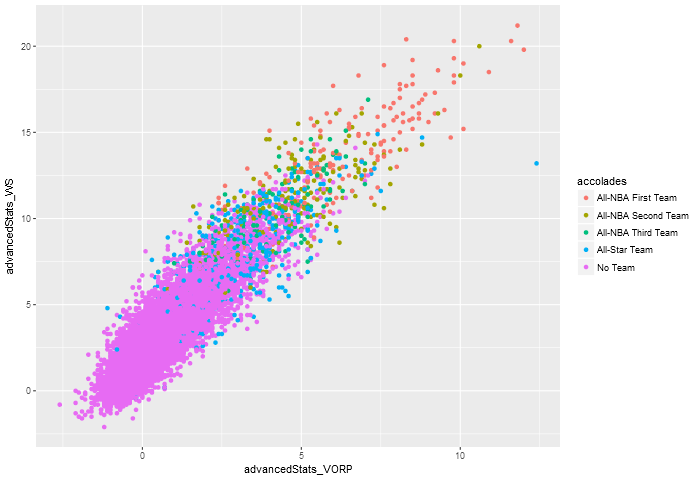

In [13]:
%%R -i playerAggDfAllNbaAllStar -w 700 -u px

ggplot(
    playerAggDfAllNbaAllStar,
    aes(
        x = advancedStats_VORP,
        y = advancedStats_WS,
        color = accolades
    )
) +
geom_point()

Perfect. Exactly what I wanted to see. A gradient starting at the top right hand corner trickling down as we go lower in the priorities. We see all those outliers in the top right as NBA 1st teams and some second teams.

First thing that jumps out to me for the all-NBA teams... **PLAYING TIME AND GAMES PLAYED MATTERS**. The fact that all those first teamers are basically dominating that corner of the plot implies that these guys played the most minutes and likely played a very high amount of games to achieve that VORP rating.

All-stars are a bit more variable, and they're kinda mixed in with those 2nd and 3rd teamers, but this is what we'd expect - these all-NBA teams can only hold 5 people per team. If it was easy to determine who these 5 people should be, there wouldn't be a voting system, right? People can approach the game and the analysis of the game in different ways... VERY different ways yielding to different votes to these teams. This implies that an all-star could have been narrowly missed from an all-NBA team, and for that matter, a non all-NBA, all-star player can be narrowly missed from either of these teams.

I just want to forget about specific teams for a second. I just want to make the distinction between someone who is on one of these teams and someone who is not.

In [14]:
playerAggDfAllNbaAllStar['accolades_any_team'] = np.where(
    playerAggDfAllNbaAllStar['accolades'] == 'No Team',
    'No Team',
    'On Team'
)

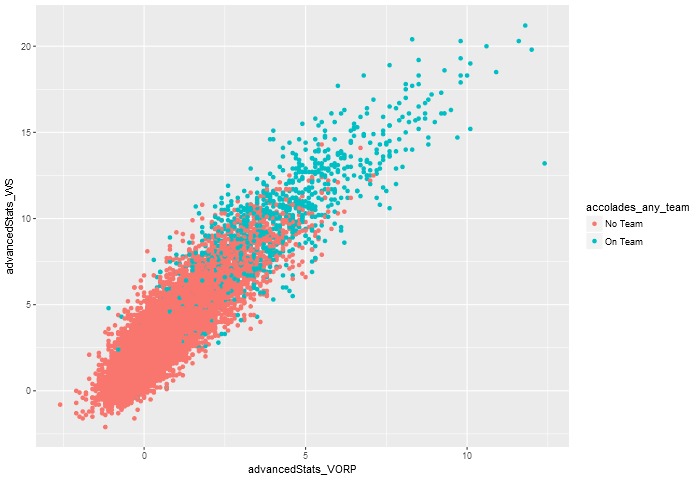

In [15]:
%%R -i playerAggDfAllNbaAllStar -w 700 -u px

ggplot(
    playerAggDfAllNbaAllStar,
    aes(
        x = advancedStats_VORP,
        y = advancedStats_WS,
        color = accolades_any_team
    )
) +
geom_point()

I'm super interested in those regular players that were left off all teams, and the (presumably) all stars that were extremelyl low on the VORP and WS scale...

### Great Players, No Accolades
Let's check out the players with great cumulative VORP + WS, but no accolades

In [16]:
# Create aggregate VORP + WS metric
playerAggDfAllNbaAllStar['VORP_WS_sum'] = playerAggDfAllNbaAllStar['advancedStats_VORP'] + playerAggDfAllNbaAllStar['advancedStats_WS']

# Filter for those on no teams and sort by highest VORP / WS sum
playerAggDfAllNbaAllStar[playerAggDfAllNbaAllStar['accolades_any_team'] == 'No Team'].sort_values('VORP_WS_sum', ascending = False)[[
    'season_start_year',
    'perGameStats_Player',
    'perGameStats_Tm',
    'perGameStats_G',
    'perGameStats_MP',
    'advancedStats_VORP',
    'advancedStats_WS',
    'per100Stats_PTS',
    'per100Stats_TRB',
    'per100Stats_AST',
    'per100Stats_STL',
    'per100Stats_BLK',
    'per100Stats_TOV'
]].head(20)

,season_start_year,perGameStats_Player,perGameStats_Tm,perGameStats_G,perGameStats_MP,advancedStats_VORP,advancedStats_WS,per100Stats_PTS,per100Stats_TRB,per100Stats_AST,per100Stats_STL,per100Stats_BLK,per100Stats_TOV
3602,1991,Horace Grant,CHI,81,35.3,6.7,14.1,20.4,14.4,3.9,1.8,2.3,1.7
12939,2016,Rudy Gobert,UTA,80,33.9,5.5,14.3,21.7,19.8,1.9,0.9,4.1,2.8
5184,1996,Mookie Blaylock,ATL,78,39.2,7.1,12.5,24.5,7.5,8.4,3.8,0.4,3.3
6382,2000,Steve Francis,HOU,80,39.9,7.0,12.2,26.4,9.2,8.6,2.3,0.5,4.4
6678,2001,Brent Barry,SEA,81,37.5,6.0,12.1,20.6,7.8,7.6,2.6,0.7,2.9
3689,1991,Larry Nance,CLE,81,35.6,5.7,12.2,24.1,11.8,4.1,1.4,4.3,1.5
5165,1996,Kenny Anderson,POR,82,37.6,5.5,12.4,24.6,6.2,10.0,2.8,0.3,3.3
3386,1990,Scottie Pippen*,CHI,82,36.8,6.4,11.2,24.3,9.9,8.5,3.2,1.5,3.9
13173,2016,Karl-Anthony Towns,MIN,81,37.0,5.2,12.4,34.5,16.7,3.7,0.9,1.7,3.6
5389,1996,Reggie Miller*,IND,81,36.6,5.2,12.3,31.8,5.2,5.0,1.4,0.5,3.0


Perfect, there you go. Two 2016's in there so I can actually speak to what I know. Two players are Rudy Gobert and KAT.

Literally a quote from post \#16 where I analyzed the PCA bi-plots and picked out all-stars this year:
>_**Wow, west forwards are pretty stacked. I see why the likes of KAT and Gobert got cut**_

And there lies at least one reason why these guys exist... **there are only so many spots every year**. Note that these 2016 guys haven't had all-NBA teams come out yet, and Gobert could possibly be on the list here, but in all likelihood KAT probably won't make any team despite his 12.4 / 5.2 on WS / VORP...

One thing is extremely clear from these numbers of the top 20 "snubs". **they all played a ton of minutes in a ton of games**. Nobody on this list played less than 78 games, and averaged pretty much at least 35 minutes within the games they played. That is MINUTES, clearly a factor for both WS and VORP.

We see a great 2012 Curry in there with great splits as well, if we look at west guards that season... CP3, Kobe, James Harden, Tony Parker, Russ. What were their stats like?

In [17]:
playerAggDfAllNbaAllStar[
    (playerAggDfAllNbaAllStar['season_start_year'] == 2012) &
    (playerAggDfAllNbaAllStar['perGameStats_Player'].isin(['Stephen Curry', 'James Harden', 'Chris Paul', 'Kobe Bryant', 'Tony Parker', 'Russell Westbrook']))
][[
    'season_start_year',
    'perGameStats_Player',
    'perGameStats_Tm',
    'perGameStats_G',
    'perGameStats_MP',
    'advancedStats_VORP',
    'advancedStats_WS',
    'per100Stats_PTS',
    'per100Stats_TRB',
    'per100Stats_AST',
    'per100Stats_STL',
    'per100Stats_BLK',
    'per100Stats_TOV'
]]

,season_start_year,perGameStats_Player,perGameStats_Tm,perGameStats_G,perGameStats_MP,advancedStats_VORP,advancedStats_WS,per100Stats_PTS,per100Stats_TRB,per100Stats_AST,per100Stats_STL,per100Stats_BLK,per100Stats_TOV
11124,2012,Kobe Bryant,LAL,78,38.6,5.1,10.9,36.0,7.3,7.9,1.8,0.4,4.8
11156,2012,Stephen Curry,GSW,78,38.2,5.6,11.2,30.4,5.3,9.2,2.1,0.2,4.1
11227,2012,James Harden,HOU,78,38.3,5.7,12.8,33.8,6.3,7.6,2.4,0.6,4.9
11364,2012,Tony Parker,SAS,66,32.9,2.6,9.3,31.4,4.6,11.7,1.3,0.1,4.0
11369,2012,Chris Paul,LAC,70,33.4,5.6,13.9,26.7,5.9,15.3,3.8,0.2,3.6
11466,2012,Russell Westbrook,OKC,82,34.9,5.1,11.6,34.2,7.7,10.9,2.6,0.4,4.9


All of these seem deserving for sure. The only questionable stats there is Tony Parker, but even then he was putting up some pertty efficient numbers despite his lower VORP / WS. Tony Parker was playing less minutes than most as well, but he had a solid 31 / 12 on PTS / AST per 100... nothing to laugh at. It's also worth noting that Tony Parker played on a much more winning team as well. By the beginning of Feb (around all-star time), SAS had 10 more wins than GSW did, so it looks like the media elected to reward winning. Perhaps a thought later to actually add winning into this equation.

All in all. The case can still be made for Steph Curry to not make any teams, but it's pretty clear he was already balling out 5 years ago.

### Great Accolades, Questionable Stats
Let's do the opposite for players who made all-star teams / all-nba teams and had pretty low VORP / WS.

In [18]:
# Filter for those on no teams and sort by highest VORP / WS sum
playerAggDfAllNbaAllStar[playerAggDfAllNbaAllStar['accolades_any_team'] == 'On Team'].sort_values('VORP_WS_sum', ascending = True)[[
    'season_start_year',
    'perGameStats_Player',
    'perGameStats_Age',
    'perGameStats_Tm',
    'perGameStats_G',
    'perGameStats_MP',
    'advancedStats_VORP',
    'advancedStats_WS',
    'per100Stats_PTS',
    'per100Stats_TRB',
    'per100Stats_AST',
    'per100Stats_STL',
    'per100Stats_BLK',
    'per100Stats_TOV',
    'accolades'
]].head(20)

,season_start_year,perGameStats_Player,perGameStats_Age,perGameStats_Tm,perGameStats_G,perGameStats_MP,advancedStats_VORP,advancedStats_WS,per100Stats_PTS,per100Stats_TRB,per100Stats_AST,per100Stats_STL,per100Stats_BLK,per100Stats_TOV,accolades
12424,2015,Kobe Bryant,37,LAL,66,28.2,-0.2,-0.4,31.3,6.7,5.0,1.7,0.4,3.5,All-Star Team
10010,2009,Allen Iverson*,34,PHI,25,31.9,-0.4,0.6,22.9,4.9,6.7,1.2,0.1,3.7,All-Star Team
10009,2009,Allen Iverson*,34,TOT,28,30.9,-0.5,0.7,23.3,4.8,6.8,1.1,0.1,3.9,All-Star Team
11964,2014,Kobe Bryant,36,LAL,35,34.5,0.7,0.2,33.1,8.4,8.3,2.0,0.3,5.4,All-Star Team
2358,1987,Steve Johnson,30,POR,43,24.4,-0.3,1.3,29.2,10.7,2.5,0.8,1.4,5.4,All-Star Team
4525,1994,Joe Dumars*,31,DET,67,38.0,-0.4,1.7,24.6,3.2,7.5,1.5,0.1,4.4,All-Star Team
10034,2009,Chris Kaman,27,LAC,76,34.3,-0.8,2.4,28.0,14.0,2.4,0.7,1.9,4.4,All-Star Team
4299,1993,Danny Manning,27,ATL,26,35.6,0.5,1.3,22.5,9.3,4.7,2.5,1.4,4.7,All-Star Team
543,1980,Paul Westphal,30,SEA,36,29.9,0.2,2.4,26.7,3.0,6.6,2.0,0.6,3.5,All-Star Team
3384,1990,Ricky Pierce,31,SEA,32,26.3,0.1,2.5,33.3,4.4,4.3,1.3,0.1,3.2,All-Star Team


Lol, this is pretty funny. You got Kobe's last 2 season. 2 of AI's last seasons. In fact, I threw in age here because just from the memory test there are legends who are voted into the all-star game because they're close to retirement or they've just always been there so if they perform relatively well, they get in by the popular fan vote. Looking at the "accolades" field, all of these guys are all-stars who didn't make an all-nba team as well. A 41 year old KAJ, a 34 year old Shaq, a 34 year old Nique.

You definitely have some younger guys in there as well (Isiah @ 20yo)! I don't know enough about some of these older teams unfortunately to comment.

I'm curious to just take away all-stars and see what the scatterplot looks like.

In [19]:
playerAggDfAllNbaAllStar['accolades_all_nba'] = np.where(
    pd.isnull(playerAggDfAllNbaAllStar['Tm']),
    'Not All-NBA',
    'All-NBA'
)

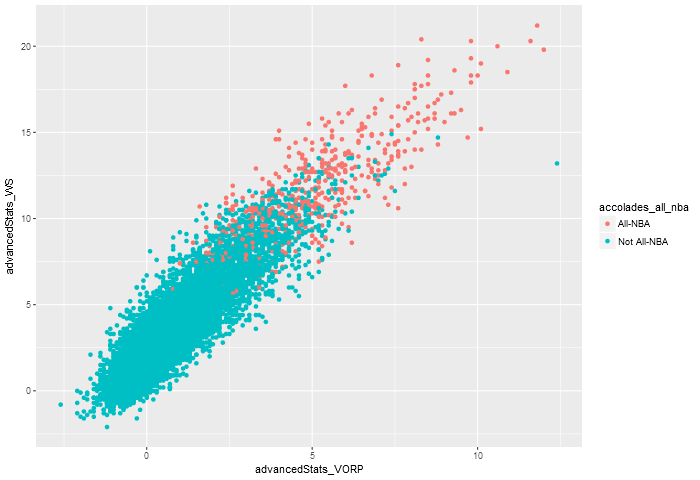

In [20]:
%%R -i playerAggDfAllNbaAllStar -w 700 -u px

ggplot(
    playerAggDfAllNbaAllStar,
    aes(
        x = advancedStats_VORP,
        y = advancedStats_WS,
        color = accolades_all_nba
    )
) +
geom_point()

Wow, even a few all-NBA players who rank pretty low on the VORP / WS scale. There are a lot more all-NBA calibre players with higher WS than VORP though, as we see you basically have to have over 7.5 WS to be considered all-NBA while there are players near 0 VORP... 0 value above a replacement player!!!

My gut instinct is that these guys are great defensive players part of championship teams... let's check this category out...

### All-NBA, High WS, Low VORP

In [45]:
playerAggDfAllNbaAllStar[playerAggDfAllNbaAllStar['accolades_all_nba'] == 'All-NBA'].sort_values('advancedStats_VORP', ascending = True)[[
    'season_start_year',
    'perGameStats_Player',
    'perGameStats_Age',
    'perGameStats_Tm',
    'perGameStats_G',
    'perGameStats_MP',
    'advancedStats_BPM',
    'advancedStats_VORP',
    'advancedStats_WS',
    'per100Stats_PTS',
    'per100Stats_TRB',
    'per100Stats_AST',
    'per100Stats_STL',
    'per100Stats_BLK',
    'per100Stats_TOV'
]].head(20)

,season_start_year,perGameStats_Player,perGameStats_Age,perGameStats_Tm,perGameStats_G,perGameStats_MP,advancedStats_BPM,advancedStats_VORP,advancedStats_WS,per100Stats_PTS,per100Stats_TRB,per100Stats_AST,per100Stats_STL,per100Stats_BLK,per100Stats_TOV
4420,1993,Dominique Wilkins*,34,LAC,25,37.9,0.0,0.5,2.6,37.0,8.9,2.8,1.5,0.4,2.6
286,1980,Tiny Archibald*,32,BOS,80,35.3,-1.3,0.5,6.9,18.7,3.0,10.4,1.3,0.3,4.5
11781,2013,Tony Parker,31,SAS,68,29.4,-0.5,0.8,5.9,28.7,3.9,9.8,0.9,0.2,3.8
12467,2015,Andre Drummond,22,DET,81,32.9,-0.5,1.0,7.4,24.9,22.7,1.3,2.3,2.1,2.9
6514,2000,Dikembe Mutombo*,34,PHI,26,33.7,2.5,1.0,3.7,18.4,19.5,1.3,0.5,4.0,3.1
9418,2008,Carmelo Anthony,24,DEN,66,34.5,0.3,1.3,5.0,33.6,10.1,5.0,1.7,0.5,4.5
6513,2000,Dikembe Mutombo*,34,ATL,49,35.0,0.9,1.3,4.5,13.5,21.1,1.6,0.6,4.2,2.8
3315,1990,Bernard King*,34,WSB,64,37.5,0.1,1.3,3.5,37.2,6.5,6.0,1.1,0.3,5.2
4419,1993,Dominique Wilkins*,34,ATL,49,34.4,1.4,1.4,5.8,36.1,9.2,3.4,1.9,0.7,3.6
11907,2014,LaMarcus Aldridge,29,POR,71,35.4,0.3,1.4,8.6,33.7,14.7,2.5,1.0,1.4,2.5


So, somehow, nobody on this last has a VORP of higher than 1.8. This means that no one on this list has a BPM of higher than -0.2. In fact, some have VORPs close to 0, which mean they are _**being valued close to a replacement player**_. How is this possible?

2013-2014 Tony Parker. VORP of 0.8, BPM of -1.2. The guy had 5.9 WS, which is decent, but -1.2 BPM when a replacement player is supposedly -2 BPM? If you replaced Tony Parker with a guy who's _**out of any NBA rotation**_, you'd only be losing 0.8 points?? That sounds blasphemous. That year, Tony Parker had 29 / 10 on PTS / AST per 100 poss. Also had 4 TOV per 100 poss, which I'd have to look back and see if TOV is extremely highly weighted in the BPM regression model, but the only other thing that really jumps out at me is that he missed 14 games on the season. But his VORP is friggin 0.8 which means unadjusted for games played he'd only be sitting at like 1.

2015-2016 Klay Thompson is also an interesting one with a VORP of 1.8. He was basically their second scoring option that season and went to the finals. Even dropped 37 points in a quarter (I think that was this season, right?). He had 32 PTS per 100 poss, but I guess he didn't do much else. 5.5 / 3 / 1 / 1 on TRB / AST / STL / BLK is nothing to really celebrate about, and I suppose these _**could**_ be the numbers of a "league average" player. I guess it's just such an interesting thought because you know Klay is one of the best two-way players in the league and is usually tasked with guarding the best player on the opposing team. He's also a key offensive piece in the league-best GSW offense.

Looking at what terms make up, or are most important in bball-ref's BPM calculation:

![](https://s3.ca-central-1.amazonaws.com/2017edmfasatb/fas_boto/images/bpm_coefficients.png)

[Bball-ref's BPM page](http://www.basketball-reference.com/about/bpm.html) goes through in much more detail what each of these sections / terms mean, so I won't repeat it here, but they use a bunch of advanced stats to calculate their coefficients. Maybe I should look at a few of these metrics (e.g. bball-ref uses AST% instead of just vanilla AST / 100 poss) to see if it makes more sense.

In [46]:
playerAggDfAllNbaAllStar[playerAggDfAllNbaAllStar['accolades_all_nba'] == 'All-NBA'].sort_values('advancedStats_VORP', ascending = True)[[
    'season_start_year',
    'perGameStats_Player',
    'perGameStats_Age',
    'perGameStats_Tm',
    'perGameStats_G',
    'perGameStats_MP',
    'advancedStats_BPM',
    'advancedStats_VORP',
    'per100Stats_ORtg',
    'per100Stats_DRtg',
    'advancedStats_WS',
    'advancedStats_TSPerc',
    'advancedStats_ORBPerc',
    'advancedStats_DRBPerc',
    'advancedStats_ASTPerc',
    'advancedStats_STLPerc',
    'advancedStats_BLKPerc',
    'advancedStats_TOVPerc',
    'advancedStats_USGPerc',
]].head(20)

,season_start_year,perGameStats_Player,perGameStats_Age,perGameStats_Tm,perGameStats_G,perGameStats_MP,advancedStats_BPM,advancedStats_VORP,per100Stats_ORtg,per100Stats_DRtg,advancedStats_WS,advancedStats_TSPerc,advancedStats_ORBPerc,advancedStats_DRBPerc,advancedStats_ASTPerc,advancedStats_STLPerc,advancedStats_BLKPerc,advancedStats_TOVPerc,advancedStats_USGPerc
4420,1993,Dominique Wilkins*,34,LAC,25,37.9,0.0,0.5,110.0,111.0,2.6,0.535,7.1,12.5,10.3,1.5,0.5,7.1,31.9
286,1980,Tiny Archibald*,32,BOS,80,35.3,-1.3,0.5,111.0,107.0,6.9,0.582,1.5,5.4,28.5,1.3,0.4,21.8,17.5
11781,2013,Tony Parker,31,SAS,68,29.4,-0.5,0.8,110.0,107.0,5.9,0.555,1.0,7.5,31.7,0.9,0.3,12.9,26.5
12467,2015,Andre Drummond,22,DET,81,32.9,-0.5,1.0,103.0,98.0,7.4,0.499,15.6,34.2,4.4,2.3,3.2,10.5,24.1
6514,2000,Dikembe Mutombo*,34,PHI,26,33.7,2.5,1.0,115.0,95.0,3.7,0.580,15.7,25.7,4.1,0.5,5.5,16.5,16.2
9418,2008,Carmelo Anthony,24,DEN,66,34.5,0.3,1.3,105.0,107.0,5.0,0.532,5.6,17.0,18.1,1.7,0.8,12.3,31.5
6513,2000,Dikembe Mutombo*,34,ATL,49,35.0,0.9,1.3,105.0,97.0,4.5,0.528,12.1,33.0,5.0,0.6,5.7,17.9,13.4
3315,1990,Bernard King*,34,WSB,64,37.5,0.1,1.3,103.0,111.0,3.5,0.527,5.2,9.4,21.8,1.1,0.4,12.9,34.4
4419,1993,Dominique Wilkins*,34,ATL,49,34.4,1.4,1.4,109.0,104.0,5.8,0.526,7.7,12.2,11.9,1.9,0.8,9.5,32.0
11907,2014,LaMarcus Aldridge,29,POR,71,35.4,0.3,1.4,108.0,102.0,8.6,0.528,7.7,22.9,9.2,1.0,1.9,7.2,30.2


Well, these are now completely new numbers unfortunately, and I'll definitely have to do a scatterplot matrix of some of these really quick.

In [23]:
# Print out summary statistics
playerAggDfAllNbaAllStar[[
    'advancedStats_TSPerc',
    'advancedStats_ORBPerc',
    'advancedStats_DRBPerc',
    'advancedStats_ASTPerc',
    'advancedStats_STLPerc',
    'advancedStats_BLKPerc',
    'advancedStats_TOVPerc',
    'advancedStats_USGPerc'
]].describe()

,advancedStats_TSPerc,advancedStats_ORBPerc,advancedStats_DRBPerc,advancedStats_ASTPerc,advancedStats_STLPerc,advancedStats_BLKPerc,advancedStats_TOVPerc,advancedStats_USGPerc
count,13220.000000,13220.000000,13220.000000,13220.000000,13220.000000,13220.000000,13220.000000,13220.000000
mean,0.525098,5.909576,13.911815,14.031483,1.661241,1.448343,14.312761,19.055401
std,0.048700,3.725254,5.768245,9.224333,0.675397,1.459221,4.126310,4.733971
min,0.231000,0.000000,3.000000,0.000000,0.000000,0.000000,2.600000,4.200000
25%,0.495000,2.600000,9.200000,7.100000,1.200000,0.500000,11.400000,15.800000
50%,0.527000,5.200000,12.900000,11.200000,1.600000,0.900000,13.800000,18.800000
75%,0.556000,8.700000,18.200000,18.900000,2.000000,1.900000,16.700000,22.200000
max,0.762000,23.100000,38.000000,57.500000,5.800000,10.800000,37.000000,41.800000


<IPython.core.display.Javascript object>


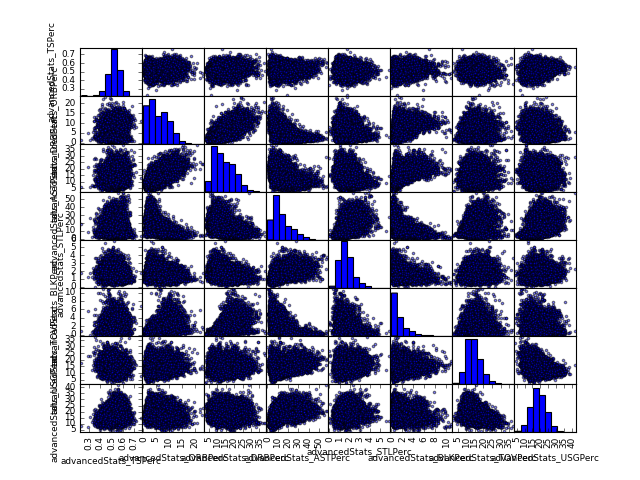

[[None],
 [None],
 [None],
 [None],
 [None],
 [None],
 [None],
 [None],
 [None],
 [None],
 [None],
 [None],
 [None],
 [None],
 [None],
 [None],
 [None],
 [None],
 [None],
 [None],
 [None],
 [None],
 [None],
 [None],
 [None],
 [None],
 [None],
 [None],
 [None],
 [None],
 [None],
 [None],
 [None],
 [None],
 [None],
 [None],
 [None],
 [None],
 [None],
 [None],
 [None],
 [None],
 [None],
 [None],
 [None],
 [None],
 [None],
 [None],
 [None],
 [None],
 [None],
 [None],
 [None],
 [None],
 [None],
 [None],
 [None],
 [None],
 [None],
 [None],
 [None],
 [None],
 [None],
 [None]]

In [24]:
from pandas.tools.plotting import scatter_matrix

# Build scatterplot matrix
ax = scatter_matrix(playerAggDfAllNbaAllStar[[
    'advancedStats_TSPerc',
    'advancedStats_ORBPerc',
    'advancedStats_DRBPerc',
    'advancedStats_ASTPerc',
    'advancedStats_STLPerc',
    'advancedStats_BLKPerc',
    'advancedStats_TOVPerc',
    'advancedStats_USGPerc'
]])

# We have to set axis labels manaully with Pandas' scatter_matrix function. Maybe there's a better function out there for
#   scatterplot matrices, but for now, this is fairly simple.
[plt.setp(item.xaxis.get_label(), 'size', 8) for item in ax.ravel()]
[plt.setp(item.yaxis.get_label(), 'size', 8) for item in ax.ravel()]

Okay, sorry, a ton of information. Definitely not the most efficient way to look at this data, but I have a bit of a better foothold on the numbers now.

If I take the guys I picked out and look at their % stats across the board, I dunno... I guess they kind of _**are**_ average. Klay across the board is basically below average except for his shooting which is a bit of an outlier in the favourable direction. But by these stats, I guess he really didn't rebound, assist, steal, or block too much more than your average player. Tony Parker scores quite a bit and gets quiet a bit of assists, but he as well, has "average" stats across the board otherwise.

If we look at a guy like the 2015-2016 Andre Drummond. Decent scoring, great rebounding, decent steals, decent blocks, decent turnovers... he's above average in many categories, but there is he, the _**4th lowest VORP**_ all-time for an all-nba guy...

Looking at the coefficients a bit closer, it seems that a few of the terms have significant coefficients (to my naive eye).
- STL%
- TO%\*USG%
- AST%\*TRB%

Andre Drummond played 81 games that season that a decent amount of minutes, so it's not the playing time / opportunities that dropped his VORP. The only thing I can think of here is that interaction term between AST and TRB because he assisted in very very little shots. Let's do an exercise to see how his BPM would have been tweaked given higher AST%.

$$AST\ and\ TRB\ Interaction=0.73\times\sqrt{AST\%\times\ TRB\%}$$

Andre Drummond had 15% ORB% and 34% DRB%. Let's just generalize this to 30%. He only had an AST% of 4%.

$$AST\ and\ TRB\ Interaction=0.73\times\sqrt{4\times30}=8.22$$

If he had brought his AST% up to, let's say, 8% (I'm not sure how unreasonable that is), he would have had

$$AST\ and\ TRB\ Interaction=0.73\times\sqrt{8\times30}=11.6$$

He would have raised his BPM by nearly 3.5 points. This would have catapulted him out of this list for sure. Even an increase of 2% in AST% would have brought his BPM up by almost 2 points, moving him up quite a few spots on this list.

The interaction term definitely seems to play a role here. Otherwise, we see many folks who simply didn't play that many games. Maybe one of the most interesting ones is _**Yao Ming**_ in 06-07 making an all-nba team while only playing 48 games. Holy cow. Rajon Rondo playing 53 games (albeit putting up _**ABSURD**_ AST% of 53% and still maintaining an average TRB%... Crazy. Guess a lot of these guys just meant a lot to their team (they have high win shares after all... right?). Clearly VORP doesn't tell the whole story as we've seen here.

_**Win Shares**_, on the other hand, is... well... it's complicated. As bball-ref states...
>The formulas are quite detailed, so I would point you to Oliver's book Basketball on Paper for complete details.

Win shares are made up of offensive win shares and defensive win shares the concepts of _**points produced**_ and _**points allowed**_ respectively (leading to _**ORtg**_ and _**DRtg**_ for players). These are calculated from pure box score statistics and kind of work backwards from VORP.

VORP is taking data and finding coefficients of the different predictors by using regression as a means to do so. In essence, we're letting the data speak to itself to figure out how the different box score stats matter. WS on the other hand (and like most other metrics) is explicitly giving a chosen value to the different predictors and we are emulating _**ORtg**_ and _**DRtg**_, then using the pythagorean formula to calculate the "wins".

We saw that no win shares are generally below 7.5 for an all-nba type of player. Again, our wins formula is as follows:

$$NBA\ Wins=\frac{(Points\ Scored)^{13.91}}{(Points\ Scored)^{13.91}+(Points\ Allowed)^{13.91}}$$

Let's take an average player with an average DRtg:

In [30]:
# Average DRtg
averageDrtg = playerAggDfAllNbaAllStar['per100Stats_DRtg'].mean()
print 'The average player\'s DRtg is {}'.format(averageDrtg)

The average player's DRtg is 106.816868381


And then let's plot what a player's ORtg would have to be to generate at least 7.5 win shares.

<IPython.core.display.Javascript object>


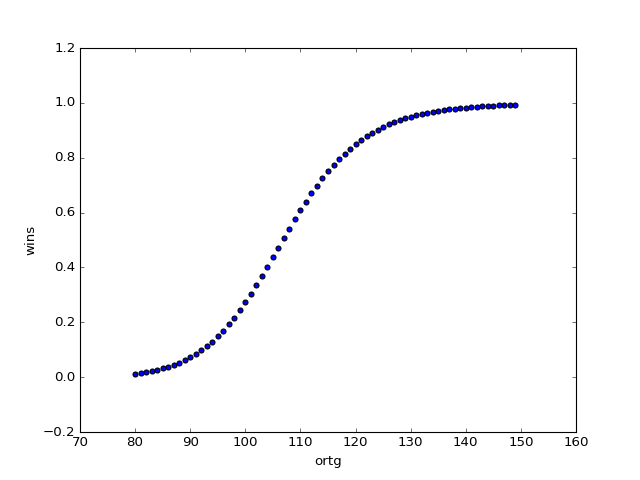

In [42]:
# Generate a list of ORtg to test
ortg = range(80, 150)

# Generate the wins
wins = [(x**14.91) / (x**14.91 + averageDrtg**14.91) for x in ortg]

# Plot ORtg vs Wins generated
pd.DataFrame({
    'ortg': ortg,
    'wins': wins
}).plot(
    kind = 'scatter',
    x = 'ortg',
    y = 'wins'
)

Okay, so the wins as a function of ORtg is essentially a sigmoid function. Let's dive deeper into the realistic values

<IPython.core.display.Javascript object>


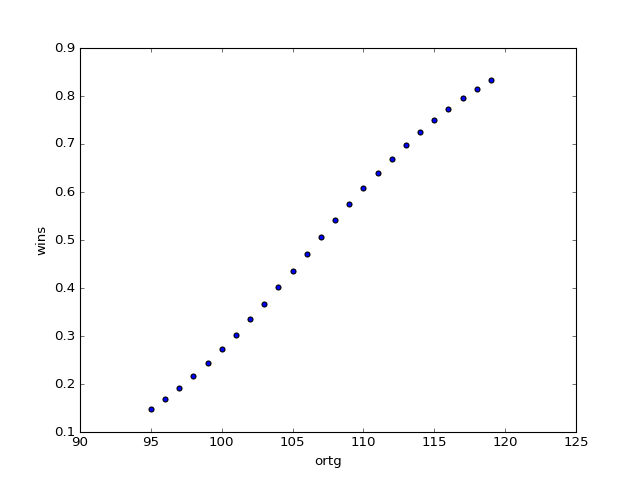

In [43]:
# Generate a list of ORtg to test
ortg = range(95, 120)

# Generate the wins
wins = [(x**14.91) / (x**14.91 + averageDrtg**14.91) for x in ortg]

# Plot ORtg vs Wins generated
pd.DataFrame({
    'ortg': ortg,
    'wins': wins
}).plot(
    kind = 'scatter',
    x = 'ortg',
    y = 'wins'
)

In the middle of the plot there, we're at every 1 point increase in ORtg increases our % of wins by 4%! Near the ends, 1 point increase in ORtg increases our % of wins by 2%. That's a pretty significant increase, so we see how WS values both offense and defense, whatever widens the gap between the two.

Let's go back to our objective here... What would cause someone to have _**high win shares, but low VORP?**_ Well, I think the point has to come back to those interaction terms of BPM... in my mind (and I really don't know the answer here and I think it's completely debateable) BPM is just a bit more of a complex model, or rather, it's just a different model. Again, those interaction terms are really important to VORP! Look back at Andre Drummond with a 1.0 VORP... he has 7.4 win shares. The 2015 pistons only had 44 wins, so he accounted for 16% of his teams wins! Not too shabby. Win shares valued him decently high, clearly better than a replacement player, right? He is a relatively one-dimensional big man, and that seems like the types of players that VORP doesn't seem to like. VORP likes talented players doing a bit of everything and it's just unfortunate if you're better at blocking than stealing, because stealing is worth so much more. Going down the list, we see many one-dimensional big men... Dikembe, Drummond, Aldrige, Jermaine O'Neal, Amare... were these guys bad? Definitely not, they made an all-nba team for god's sakes, but they definitely were not the type of players that VORP liked!

### For Funsies...
#### Highest VORP of All Time
There's a guy that has insane VORP, clearly better than the rest, and not an all-nba player. Let's check him out.

In [47]:
# Player with highest VORP of all time (no all-nba team)
playerAggDfAllNbaAllStar[playerAggDfAllNbaAllStar['advancedStats_VORP'] == playerAggDfAllNbaAllStar['advancedStats_VORP'].max()]

,season_start_year,perGameStats_Player,perGameStats_Pos,perGameStats_Age,perGameStats_Tm,perGameStats_G,perGameStats_GS,perGameStats_MP,per100Stats_FG,per100Stats_FGA,...,advancedStats_VORP,player_formatted,Tm,Player_x,Player_y,all_star,accolades,accolades_any_team,VORP_WS_sum,accolades_all_nba
13194,2016,Russell Westbrook,PG,28,OKC,80,80.0,34.8,14.5,34.1,...,12.4,russellwestbrook,NaN,NaN,Russell Westbrook,All Star,All-Star Team,On Team,25.6,Not All-NBA


Okay, I swear Russ was on the tip of my toungue... This season isn't over yet. He'll probably make an All-NBA team. Crazy that he is THE HIGHEST OF ALL TIME though... NEXT!

Let's save the aggregated player / all-star / all-nba data so we can use it next time.

In [48]:
# Save data to S3 so we can use it for future analysis
csv_buffer = StringIO()
playerAggDfAllNbaAllStar.to_csv(csv_buffer)
s3_resource = boto3.resource('s3')
s3_resource.Object('2017edmfasatb', 'fas_boto/data/playerAggDfAllNbaAllStar.csv').put(Body=csv_buffer.getvalue())

{u'ETag': '"721119d1fb1e4e321eb1e0721d8093a2"',
 'ResponseMetadata': {'HTTPHeaders': {'content-length': '0',
   'date': 'Thu, 04 May 2017 23:46:34 GMT',
   'etag': '"721119d1fb1e4e321eb1e0721d8093a2"',
   'server': 'AmazonS3',
   'x-amz-id-2': 'AqUbX6PIlHN0YnhCnH6x8AJ5ATJB0wN6omI1Twtwf0/jQYVscnkuwmYVNM4aa4yj6DvpyA7AwCQ=',
   'x-amz-request-id': 'C94F2679CAE3773D'},
  'HTTPStatusCode': 200,
  'HostId': 'AqUbX6PIlHN0YnhCnH6x8AJ5ATJB0wN6omI1Twtwf0/jQYVscnkuwmYVNM4aa4yj6DvpyA7AwCQ=',
  'RequestId': 'C94F2679CAE3773D',
  'RetryAttempts': 0}}